## Figure 12

Similar to [Figure 5](https://github.com/EdwardJKim/astroclass/blob/master/paper/notebooks/figure05/purity_mag_integrated.ipynb)
but for the reduced training set.

In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
from scipy.special import gammaln
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
plt.rc('legend', fontsize=10)

In [2]:
truth_train = np.loadtxt('../../data/truth_train.dat')
truth_test = np.loadtxt('../../data/truth_test.dat')
mask_w1_train = np.loadtxt('../../data/vvds_w1_train.mask').astype(bool)
mag_i_train = np.loadtxt('../../data/mag_i.train.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')

In [3]:
tpc_test = np.loadtxt('../../data/w1_22_0_tpc_test.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('../../data/w1_22_0_som_test.mlz', unpack=True, usecols=(2,))
hbc_all = np.loadtxt('../../data/w1_22_0_median.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:-len(truth_test)]
hbc_test = hbc_all[-len(truth_test):]
bmc_test = np.loadtxt('../../data/w1_22_0.bmc')

In [4]:
# read in FLUX_RADIUS and MAG_i and make a classification
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

r_h_test = np.loadtxt('../../data/flux_radius.test.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')
morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

In [5]:
hist_bins = np.arange(17, 25.5, 1)

In [6]:
# http://inspirehep.net/record/669498/files/fermilab-tm-2286.PDF

def calceff(N, k, conf=0.683, tol=1.0e-3, step=1.0e-3, a0=None, dx0=None, output=True):
    
    epsilon = k / N
    
    if a0 is None:
        a0 = epsilon
        
    if dx0 is None:
        dx0 = step
    
    bins = np.arange(0, 1 + step, step)
    
    def get_log_p(N, k):
        p = gammaln(N + 2) - gammaln(k + 1) - gammaln(N - k + 1) + k * np.log(bins) + (N - k) * np.log(1 - bins)
        return p
    
    alpha = np.arange(0, a0, step)
    beta = np.arange(epsilon, 1, step)
    
    log_p = get_log_p(N, k)

    def func(x):
        i = np.argmin(np.abs(bins - x))
        return np.exp(log_p[i])

    found = False

    area_best = 1
    alpha_best = alpha[-1]
    beta_best = 1.0

    dxs = np.arange(dx0, 1, step)
    
    for ix, dx in enumerate(dxs):
        
        for ia, a in enumerate(alpha[::-1]):

            b = a + dx
            
            #a = min(a, b)
            #b = max(a, b)
            
            if b > 1 or b < epsilon:
                break
         
            area, err = quad(func, a, b)
                      
            #print(area, a, b)
            
            if np.abs(area - conf) < tol:
                area_best = area
                alpha_best = a
                beta_best = b
                found = True
                break
                
            if area > conf:
                # go back a step, recalculate with smaller step
                alpha_best, beta_best, area_best = calceff(N, k, step=0.8*step, a0=a + step, dx0=dx - step, output=False)

                found = True
                # exit the inner for loop for a
                break
                    
        # exit the outer for loop for dx    
        if found:
            break
    
    if output:
        print("Done. N = {0}, k = {1}, area: {2:.3f}, alpha: {3:.4f}, beta: {4:.4f}"
              "".format(N, k, area_best, alpha_best, beta_best, step))
            
    return alpha_best, beta_best, area_best

In [7]:
def calc_completeness_purity(truth, classif, mag, p_cut=0.001, bins=np.arange(16, 26, 0.5)):
    '''
    '''
    
    bins = bins[1:]
    result = {}
    
    g_comp_bin = np.zeros(len(bins))
    g_pur_bin = np.zeros(len(bins))
    s_comp_bin = np.zeros(len(bins))    
    s_pur_bin = np.zeros(len(bins))
    
    g_pur_lower_bin = np.zeros(len(bins))
    g_pur_upper_bin = np.zeros(len(bins))

    s_pur_upper_bin = np.zeros(len(bins))
    s_pur_lower_bin = np.zeros(len(bins))

    for i, b in enumerate(bins):
                
        # true galaxies classified as stars
        mask = (mag > -90) & (mag < b)
        gs_bin = ((classif[mask] >= p_cut) & (truth[mask] == 0)).sum().astype(np.float)
        # true galaxies classified as galaxies
        gg_bin = ((classif[mask] < p_cut) & (truth[mask] == 0)).sum().astype(np.float)
        # true stars classified as galaxies
        sg_bin = ((classif[mask] < p_cut) & (truth[mask] == 1)).sum().astype(np.float)
        # true stars classified as stars
        ss_bin = ((classif[mask] >= p_cut) & (truth[mask] == 1)).sum().astype(np.float)

        # galaxy completeness
        g_comp_bin[i] = gg_bin / (gg_bin + gs_bin)    
        # galaxy purity
        g_pur_bin[i] = gg_bin / (gg_bin + sg_bin)
        
        # star completeness
        s_comp_bin[i] = ss_bin / (ss_bin + sg_bin)

        s_pur_bin[i] = ss_bin / (ss_bin + gs_bin)
        
        print("Calculating completenss for {0}...".format(b))

        g_pur_err = calceff(gg_bin + sg_bin, gg_bin)
        g_pur_lower_bin[i] = g_pur_err[0]
        g_pur_upper_bin[i] = g_pur_err[1]
        
        print("Calculating purity for {0}...".format(b))

        s_pur_err = calceff(ss_bin + gs_bin, ss_bin)
        s_pur_lower_bin[i] = s_pur_err[0]
        s_pur_upper_bin[i] = s_pur_err[1]


    result['galaxy_completeness'] = g_comp_bin
    result['galaxy_purity'] = g_pur_bin
    
    result['galaxy_purity_lower'] = g_pur_lower_bin
    result['galaxy_purity_upper'] = g_pur_upper_bin

    result['star_completeness'] = s_comp_bin
    result['star_purity'] = s_pur_bin
    
    result['star_purity_lower'] = s_pur_lower_bin
    result['star_purity_upper'] = s_pur_upper_bin
    
    return result

    
def find_purity_at(truth_test, clf, step=0.001, gc=None, gp=None, sc=None, sp=None):
    
    print("Finding the threshold value...")
    
    if bool(gc) and bool(sc) and bool(gp) and bool(sp):
        raise Exception('Specify only one of gp or sp parameter.')

    pbin = np.arange(0, 1, step)
    
    pure_all = np.zeros(len(pbin))
    comp_all = np.zeros(len(pbin))
    
    for i, p in enumerate(pbin):
        
        # true galaxies classified as stars
        gs = ((clf >= p) & (truth_test == 0)).sum()
        # true galaxies classified as galaxies
        gg = ((clf < p) & (truth_test == 0)).sum()
        # true stars classified as galaxies
        sg = ((clf < p) & (truth_test == 1)).sum()
        # true stars classified as stars
        ss = ((clf >= p) & (truth_test == 1)).sum()
    
        if gc is not None or gp is not None:
            if gg == 0 and sg == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = gg / (gg + sg)
            if gg == 0 and gs == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = gg / (gg + gs)
            
        if sc is not None or sp is not None:
            if ss == 0 and sg == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = ss / (ss + sg)
            if ss == 0 and gs == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = ss / (ss + gs)
    
    if gc is not None:
        ibin = np.argmin(np.abs(comp_all - gc))
        return pbin[ibin], pure_all[ibin]
    
    if gp is not None:
        ibin = np.argmin(np.abs(pure_all - gp))
        return pbin[ibin], comp_all[ibin]
    
    if sc is not None:
        ibin = np.argmin(np.abs(comp_all - sc))
        return pbin[ibin], pure_all[ibin]
    
    if sp is not None:
        ibin = np.argmin(np.abs(pure_all - sp))
        return pbin[ibin], comp_all[ibin]

In [8]:
morph = calc_completeness_purity(truth_test, morph_test, mag_i_test, p_cut=0.5, bins=hist_bins)

Calculating completenss for 18.0...
Done. N = 1235.0, k = 1229.0, area: 0.683, alpha: 0.9932, beta: 0.9973

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)



Calculating purity for 18.0...
Done. N = 133.0, k = 133.0, area: 1.000, alpha: 0.9990, beta: 1.0000
Calculating completenss for 19.0...
Done. N = 1821.0, k = 1810.0, area: 0.684, alpha: 0.9924, beta: 0.9962
Calculating purity for 19.0...
Done. N = 572.0, k = 571.0, area: 1.000, alpha: 0.9980, beta: 1.0000
Calculating completenss for 20.0...
Done. N = 2972.0, k = 2950.0, area: 0.682, alpha: 0.9910, beta: 0.9942
Calculating purity for 20.0...
Done. N = 894.0, k = 888.0, area: 0.683, alpha: 0.9905, beta: 0.9962
Calculating completenss for 21.0...
Done. N = 3905.0, k = 3869.0, area: 0.684, alpha: 0.9897, beta: 0.9932
Calculating purity for 21.0...
Done. N = 1256.0, k = 1214.0, area: 0.684, alpha: 0.9622, beta: 0.9726
Calculating completenss for 22.0...
Done. N = 7058.0, k = 6764.0, area: 0.682, alpha: 0.9560, beta: 0.9608
Calculating purity for 22.0...
Done. N = 1256.0, k = 1214.0, area: 0.684, alpha: 0.9622, beta: 0.9726
Calculating completenss for 23.0...
Done. N = 10237.0, k = 9798.0, 

In [9]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, gc=0.9964, step=0.0001)
bmc_mg = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=hist_bins)
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, sc=0.7145, step=0.0001)
bmc_ms = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=hist_bins)

Finding the threshold value...
Calculating completenss for 18.0...
Done. N = 1245.0, k = 1229.0, area: 0.684, alpha: 0.9843, beta: 0.9910
Calculating purity for 18.0...
Done. N = 123.0, k = 123.0, area: 1.000, alpha: 0.9990, beta: 1.0000
Calculating completenss for 19.0...
Done. N = 1846.0, k = 1809.0, area: 0.683, alpha: 0.9771, beta: 0.9838
Calculating purity for 19.0...
Done. N = 547.0, k = 545.0, area: 1.000, alpha: 0.9960, beta: 1.0000
Calculating completenss for 20.0...
Done. N = 2995.0, k = 2951.0, area: 0.683, alpha: 0.9830, beta: 0.9874
Calculating purity for 20.0...
Done. N = 871.0, k = 866.0, area: 0.683, alpha: 0.9920, beta: 0.9980
Calculating completenss for 21.0...
Done. N = 3969.0, k = 3885.0, area: 0.684, alpha: 0.9770, beta: 0.9818
Calculating purity for 21.0...
Done. N = 1192.0, k = 1166.0, area: 0.683, alpha: 0.9738, beta: 0.9823
Calculating completenss for 22.0...
Done. N = 7001.0, k = 6776.0, area: 0.682, alpha: 0.9664, beta: 0.9710
Calculating purity for 22.0...
D

In [10]:
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, gc=0.9964, step=0.0001)
tpc_mg = calc_completeness_purity(truth_test, tpc_test, mag_i_test, p_cut=tpc_p_cut, bins=hist_bins)
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, sc=0.7145, step=0.0001)
tpc_ms = calc_completeness_purity(truth_test, tpc_test, mag_i_test, p_cut=tpc_p_cut, bins=hist_bins)

Finding the threshold value...
Calculating completenss for 18.0...
Done. N = 1268.0, k = 1214.0, area: 0.683, alpha: 0.9530, beta: 0.9650
Calculating purity for 18.0...
Done. N = 100.0, k = 85.0, area: 0.682, alpha: 0.8130, beta: 0.8840
Calculating completenss for 19.0...
Done. N = 1998.0, k = 1785.0, area: 0.682, alpha: 0.8864, beta: 0.9002
Calculating purity for 19.0...
Done. N = 395.0, k = 369.0, area: 0.683, alpha: 0.9210, beta: 0.9460
Calculating completenss for 20.0...
Done. N = 3224.0, k = 2922.0, area: 0.682, alpha: 0.9019, beta: 0.9123
Calculating purity for 20.0...
Done. N = 642.0, k = 608.0, area: 0.684, alpha: 0.9390, beta: 0.9570
Calculating completenss for 21.0...
Done. N = 4310.0, k = 3873.0, area: 0.683, alpha: 0.8950, beta: 0.9045
Calculating purity for 21.0...
Done. N = 851.0, k = 813.0, area: 0.683, alpha: 0.9496, beta: 0.9644
Calculating completenss for 22.0...
Done. N = 7398.0, k = 6767.0, area: 0.683, alpha: 0.9120, beta: 0.9186
Calculating purity for 22.0...
Done

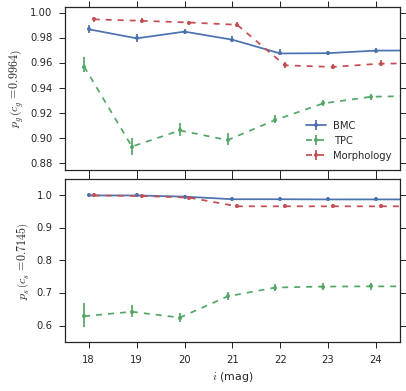

In [15]:
p = sns.color_palette()
sns.set_style("ticks")

fig = plt.figure(figsize=(6, 6))

ax0 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=3)
ax1 = plt.subplot2grid((6, 3), (3, 0), colspan=3, rowspan=3)

plt.setp(ax0.get_xticklabels(), visible=False)

x_offset = 0.1

ax0.errorbar(hist_bins[1:], bmc_mg['galaxy_purity'],
             yerr=[bmc_mg['galaxy_purity'] - bmc_mg['galaxy_purity_lower'],
                   bmc_mg['galaxy_purity_upper'] - bmc_mg['galaxy_purity']],
             label='BMC', ls='-', marker='o', markersize=4)
ax0.errorbar(hist_bins[1:] - x_offset, tpc_mg['galaxy_purity'],
             yerr=[tpc_mg['galaxy_purity'] - tpc_mg['galaxy_purity_lower'],
                   tpc_mg['galaxy_purity_upper'] - tpc_mg['galaxy_purity']],
             label='TPC', ls='--', marker='o', markersize=4)
ax0.errorbar(hist_bins[1:] + x_offset, morph['galaxy_purity'],
             yerr=[morph['galaxy_purity'] - morph['galaxy_purity_lower'],
                   morph['galaxy_purity_upper'] - morph['galaxy_purity']],
             label='Morphology', ls='--', marker='o', markersize=4)
ax0.legend(loc='lower right')

ax0.set_xlim(17.5, 24.5)
ax0.set_ylim(0.875, 1.005)
#ax0.set_yticks([0.86, 0.91.0])
ax0.set_ylabel(r'$p_g\left(c_g=0.9964\right)$', fontsize=12)

ax1.errorbar(hist_bins[1:], bmc_ms['star_purity'],
             yerr=[bmc_ms['star_purity'] - bmc_ms['star_purity_lower'],
                   bmc_ms['star_purity_upper'] - bmc_ms['star_purity']],
             label='BMC', ls='-', marker='o', markersize=4)
ax1.errorbar(hist_bins[1:] - x_offset, tpc_ms['star_purity'],
             yerr=[tpc_ms['star_purity'] - tpc_ms['star_purity_lower'],
                   tpc_ms['star_purity_upper'] - tpc_ms['star_purity']],
             label='TPC', ls='--', marker='o', markersize=4)
ax1.errorbar(hist_bins[1:] + x_offset, morph['star_purity'],
             yerr=[morph['star_purity'] - morph['star_purity_lower'],
                   morph['star_purity_upper'] - morph['star_purity']],
             label='Morphology', ls='--', marker='o', markersize=4)

ax1.set_ylabel(r'$p_s\left(c_s=0.7145\right)$', fontsize=12)
ax1.set_xlim(17.5, 24.5)
ax1.set_ylim(0.55, 1.05)
ax1.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax1.set_xlabel(r'$i$ (mag)')

plt.savefig('../../figures/purity_mag_cut_integrated.pdf')

plt.show()